# Project Name: Amex Default Prediction

## Introduction and Objective

This Jupyter Notebook is dedicated to predicting default risk using the American Express Default Prediction dataset. By leveraging advanced machine learning techniques to analyze and predict customer default likelihood, this project aims to enhance financial decision-making processes.

## Description

Credit default prediction is crucial for managing risk in a consumer lending business. This project uses an industrial-scale dataset provided by American Express, the world's largest payment card issuer, to build a model that challenges the current models in production. Through this competition, participants can apply their machine learning skills to predict credit default, potentially improving the customer experience and influencing future credit risk management.

## Dataset Overview and Description

The objective of this competition is to predict the probability that a customer will not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing an 18-month performance window after the latest credit card statement.

### Features
The dataset contains aggregated profile features for each customer at each statement date, categorized as follows:

- **D_*** = Delinquency variables
- **S_*** = Spend variables
- **P_*** = Payment variables
- **B_*** = Balance variables
- **R_*** = Risk variables

### Categorical Features:
['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

### Required Files:

- From the [Kaggle Dataset Main Page](https://www.kaggle.com/competitions/amex-default-prediction/data), download the files and place them in a `data` directory (must be accesssible by this notebook):
  - `train_labels.csv` - Target label for each customer_ID
  - `sample_submission.csv` - A sample submission file in the correct format


- From the Kaggle Feather Files from [Kaggle Feather Dataset](https://www.kaggle.com/datasets/munumbutt/amexfeather), download the `.ftr` (Feather format) files for efficient data handling and place them in the same `data` directory (must be accesssible by this notebook):
  - `train_data.ftr`
  - `test_data.ftr`

## Install Required Packages

To enhance the functionality of the environment, you may need to install some libraries not pre-installed in the CTPO environment but required for this notebook. Follow these steps to install the necessary libraries from the `requirements.txt` file:

1. Create and Activate the Virtual Environment:

Open your terminal or command prompt within the Jupyter notebook. File -> New -> Terminal and type bash to get a shell compatible with the following commands.

Navigate to the project directory where the notebook is to set up the environment.

Execute the following commands to create and activate the virtual environment:
```bash
python3 -m venv --system-site-packages myvenv
source myvenv/bin/activate
pip3 install ipykernel
python -m ipykernel install --user --name=myvenv --display-name="Python (myvenv)"
```
2. Install Required Libraries

Before running the following command in Jupyter notebook, make sure you are in the directory where the Jupyter Notebook and virtual environment is located. Load the newly created "Python (myenv)" kernel. This ensures the ./ path is always current. You can use the cd command to change to your project directory and pwd to verify your current directory.


In [ ]:
!. ./myvenv/bin/activate; pip install -r requirements.txt

In [3]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings

import pickle

warnings.filterwarnings('ignore')

## Importing Data


In [4]:
# Feather files (Compressed version of the original data to handle with pandas)
train_path = 'data/train_data.ftr'
test_path = 'data/test_data.ftr'
labels_path = 'data/train_labels.csv'

In [5]:
# Load the Feather files for train and test data
train_data = pd.read_feather(train_path)
test_data = pd.read_feather(test_path)

# Load the target labels CSV file
labels_data = pd.read_csv(labels_path)


In [6]:
# Merge the target labels with the training data
train_data = pd.merge(train_data, labels_data, on='customer_ID', how='left')

In [7]:
# Display the shapes of the dataframes
print("Shape of train data:", train_data.shape)
print("Shape of test data:", test_data.shape)
print("Shape of merged train data:", train_data.shape)

Shape of train data: (5531451, 191)
Shape of test data: (11363762, 190)
Shape of merged train data: (5531451, 191)


In [8]:
train_data.info(max_cols=train_data.shape[1] ,show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Data columns (total 191 columns):
 #    Column       Non-Null Count    Dtype   
---   ------       --------------    -----   
 0    customer_ID  5531451 non-null  object  
 1    S_2          5531451 non-null  object  
 2    P_2          5485466 non-null  float16 
 3    D_39         5531451 non-null  float16 
 4    B_1          5531451 non-null  float16 
 5    B_2          5529435 non-null  float16 
 6    R_1          5531451 non-null  float16 
 7    S_3          4510907 non-null  float16 
 8    D_41         5529435 non-null  float16 
 9    B_3          5529435 non-null  float16 
 10   D_42         791314 non-null   float16 
 11   D_43         3873055 non-null  float16 
 12   D_44         5257132 non-null  float16 
 13   B_4          5531451 non-null  float16 
 14   D_45         5529434 non-null  float16 
 15   B_5          5531451 non-null  float16 
 16   R_2          5531451 non-null  float16 
 17   D_46  

In [9]:
train_data.isnull().sum()

customer_ID          0
S_2                  0
P_2              45985
D_39                 0
B_1                  0
                ...   
D_142          4587043
D_143           101548
D_144            40727
D_145           101548
target               0
Length: 191, dtype: int64

In [10]:
train_data1 = train_data.groupby('customer_ID').tail(1).set_index('customer_ID')
test_data1 = test_data.groupby('customer_ID').tail(1).set_index('customer_ID')



# EDA
## Features weights on dataset

In [11]:
def count_features(table: pd.DataFrame) -> dict:
    '''
    This function stores all columns that belong to each feature from the DataFrame.
    '''
    features = {'Delinquency':None, 'Spend':None, 'Payment':None, 'Balance':None, 'Risk':None}

    for k, v in features.items():
        features[k] = len([c for c in table.columns if c.startswith(k[0])])
    
    return features

In [12]:
train_feat = count_features(train_data1)
test_feat = count_features(test_data1)

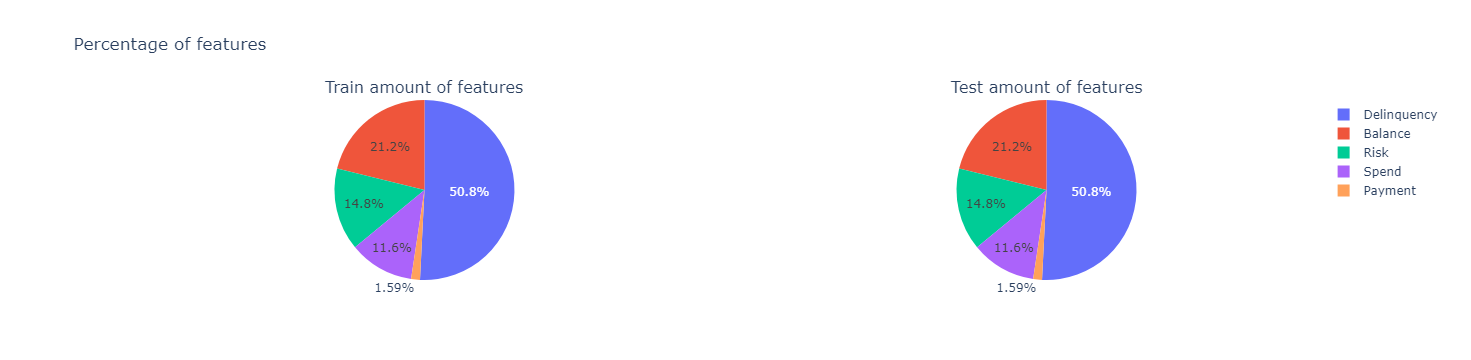

In [13]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Train amount of features', 'Test amount of features'),
    specs=[[{"type": "pie"}, {"type": "pie"}]]
)

fig.add_trace(go.Pie(
    labels=tuple(train_feat.keys()), values=tuple(train_feat.values()), name='Train'), row=1, col=1
    )

fig.add_trace(go.Pie(
    labels=tuple(test_feat.keys()), values=tuple(test_feat.values()), name='Test'), row=1, col=2
    )

fig.update_layout(
    title_text='Percentage of features'
)

fig.show()



## Missing Data

In [14]:
def null_features(table: pd.DataFrame) -> dict:
    '''
    Finds the percentage of missing data per feature of the DataFrame.
    '''
    features = {'Delinquency':None, 'Spend':None, 'Payment':None, 'Balance':None, 'Risk':None}

    for k, v in features.items():
        cols = [c for c in table.columns if c.startswith(k[0])]
        temp_df = table[cols]
        features[k] = round(np.mean(temp_df.isnull().sum()), 2)
    
    return features

In [15]:
train_miss = null_features(train_data1)
test_miss = null_features(test_data1)

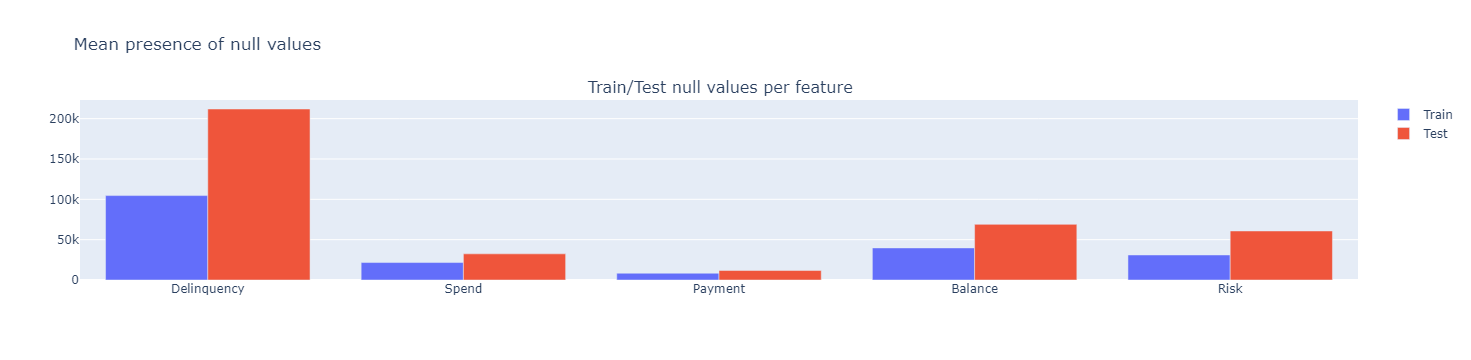

In [16]:
fig = make_subplots(
    rows=1, cols=1,
    subplot_titles=('Train/Test null values per feature', ''),
    specs=[[{"type": "bar"}]]
)

fig.add_trace(go.Bar(
    x=tuple(train_miss.keys()), y=tuple(train_miss.values()), name='Train'
))
fig.add_trace(go.Bar(
    x=tuple(test_miss.keys()), y=tuple(test_miss.values()), name='Test'
))

fig.update_layout(
    title_text='Mean presence of null values'
)

fig.show()



## Target Balance

In [17]:
target = train_data['target'].value_counts()
target_0 = round((target[0]/train_data['target'].count()*100), 2)
target_1 = round((target[1]/train_data['target'].count()*100), 2)

df_target_percentage = pd.DataFrame(data={'Target':['0', '1'], 'Percentage':[target_0, target_1]})

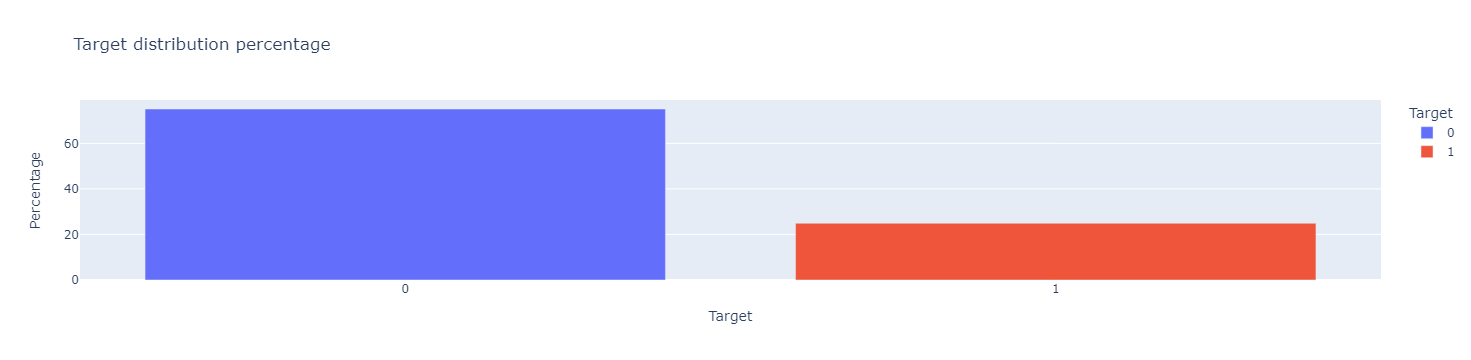

In [18]:
fig = px.bar(df_target_percentage, x='Target', y='Percentage', color='Target', title="Target distribution percentage")
fig.update_layout()
fig.show()

del target, target_0, target_1, df_target_percentage

In [19]:
print(f'Number of unique customers in train: {train_data["customer_ID"].nunique()}')
print(f'Represent the {round((train_data["customer_ID"].nunique()/len(train_data))*100, 2)}% of the train data.')
print()
print(f'Each customer appear in the data around {round(len(train_data)/train_data["customer_ID"].nunique(), 2)} times')

Number of unique customers in train: 458913
Represent the 8.3% of the train data.

Each customer appear in the data around 12.05 times


## Feature Correlation

In [20]:
Delinquency = train_data1[[c for c in train_data1.columns if c.startswith('D')] +  ['target']]
Spend       = train_data1[[c for c in train_data1.columns if c.startswith('S')] +  ['target']]
Payment     = train_data1[[c for c in train_data1.columns if c.startswith('P')] +  ['target']]
Balance     = train_data1[[c for c in train_data1.columns if c.startswith('B')] +  ['target']]
Risk        = train_data1[[c for c in train_data1.columns if c.startswith('R')] +  ['target']]

In [21]:
def plot_corr(table: pd.DataFrame, title: str, size: tuple = (12,9), annot: str = False):
    plt.figure(figsize=size)
    sns.heatmap(
        table.corr(),
        annot=annot,
        cmap='coolwarm'
    )
    plt.title(title, fontdict={'fontsize': 18});

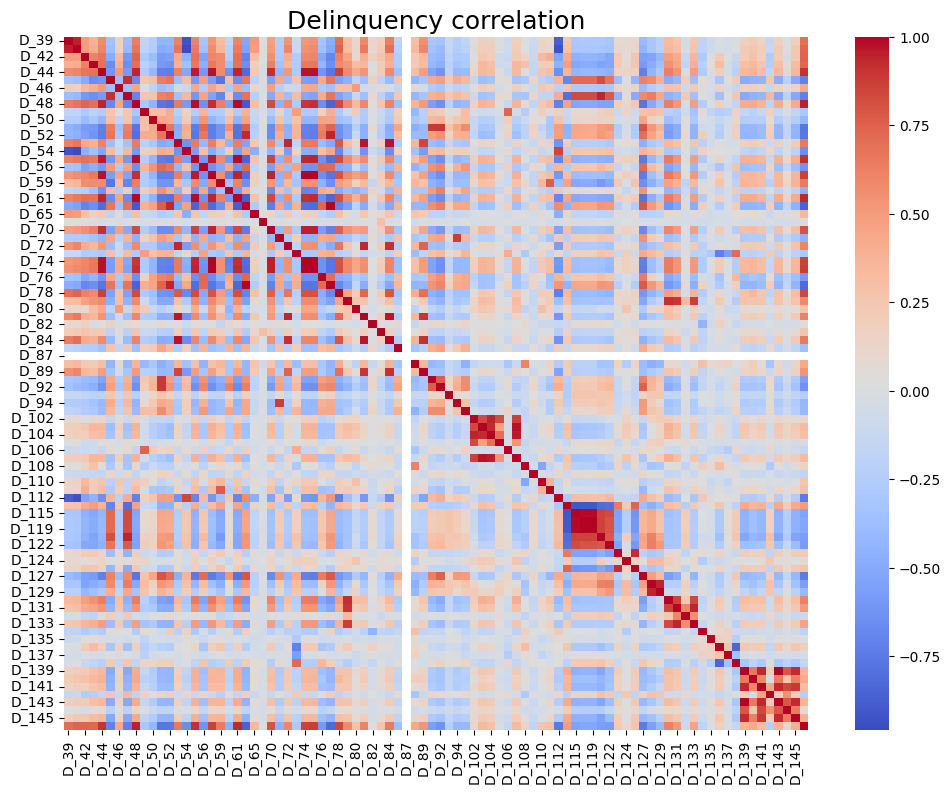

In [22]:
plot_corr(Delinquency.corr(), title='Delinquency correlation')

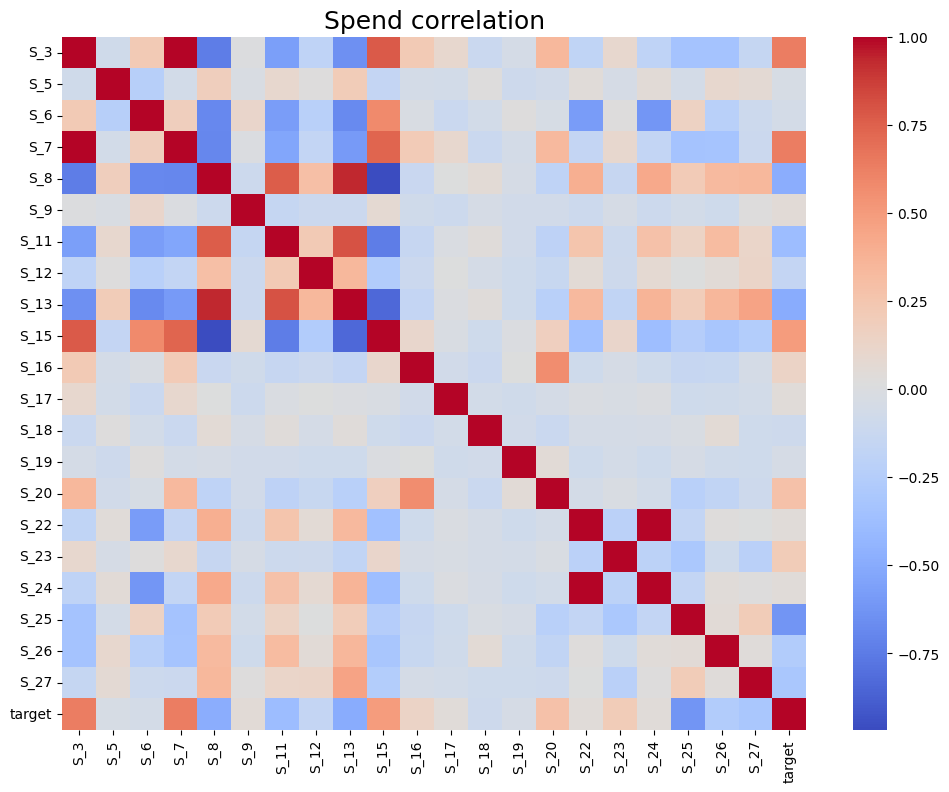

In [23]:
plot_corr(Spend.corr(), title='Spend correlation')

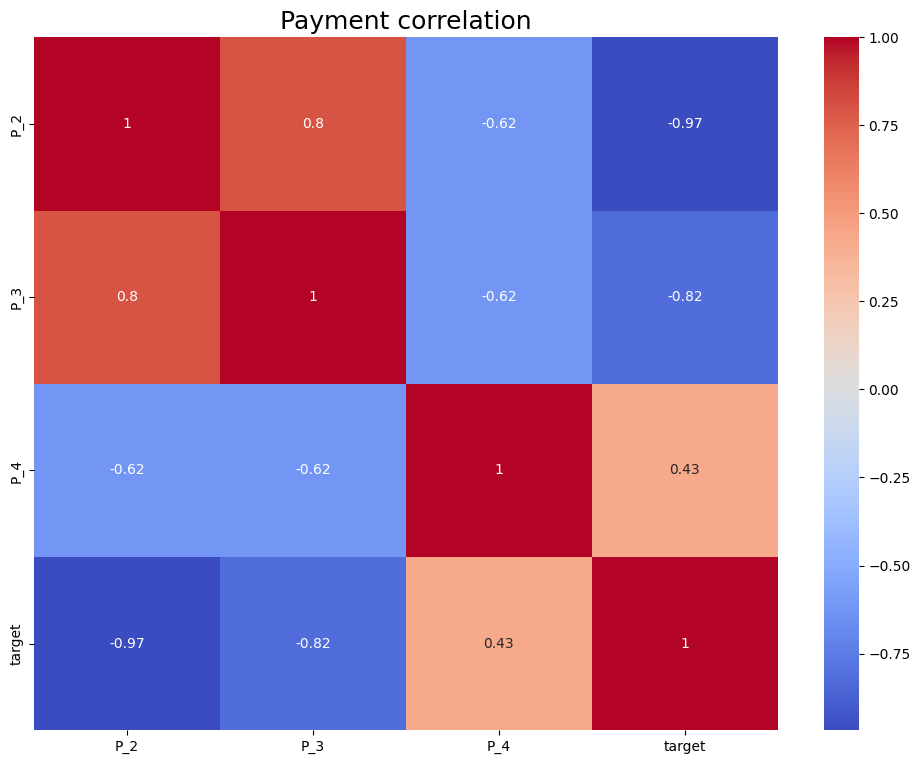

In [24]:
plot_corr(Payment.corr(), title='Payment correlation', annot=True)

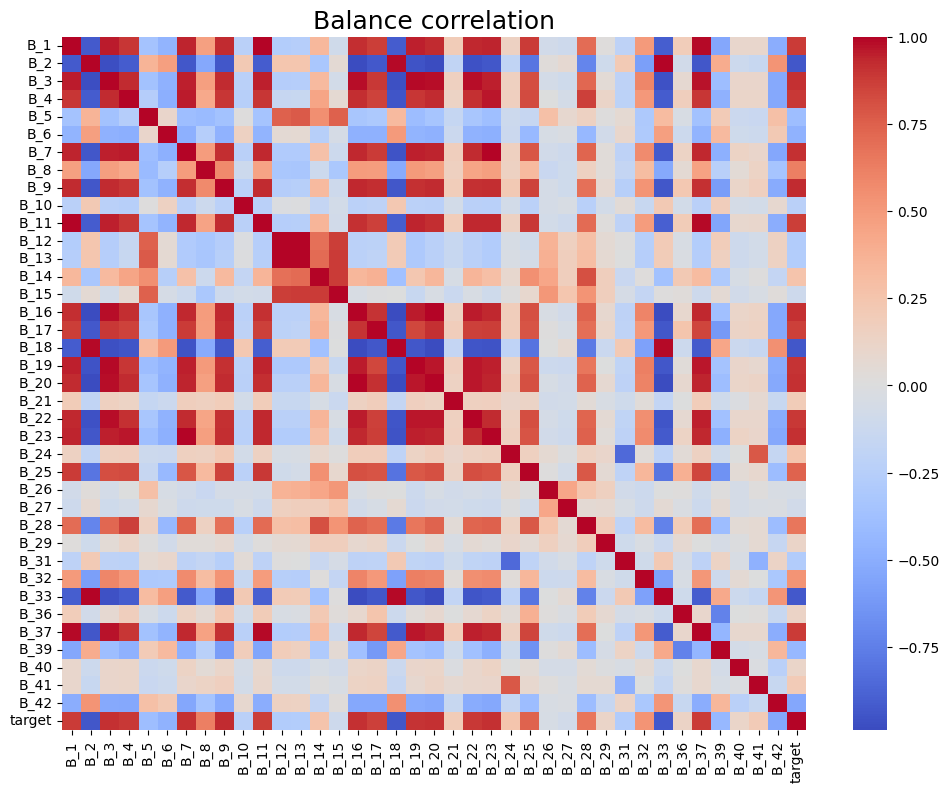

In [25]:
plot_corr(Balance.corr(), title='Balance correlation')

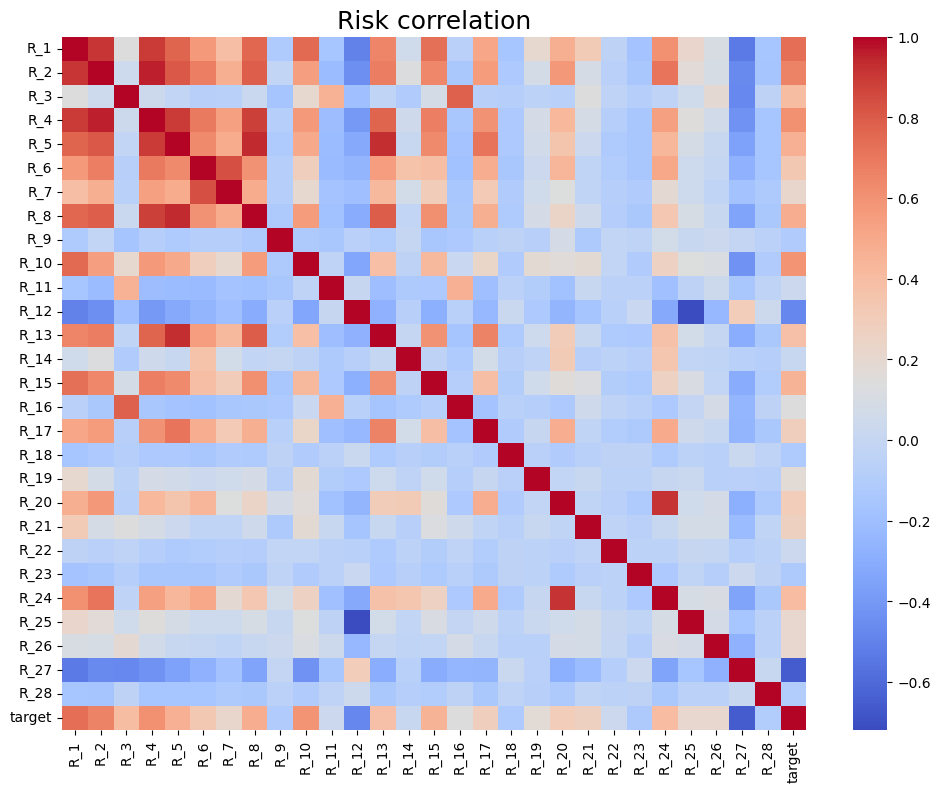

In [26]:
plot_corr(Risk.corr(), title='Risk correlation')

In [27]:
del Delinquency, Spend, Payment, Balance, Risk

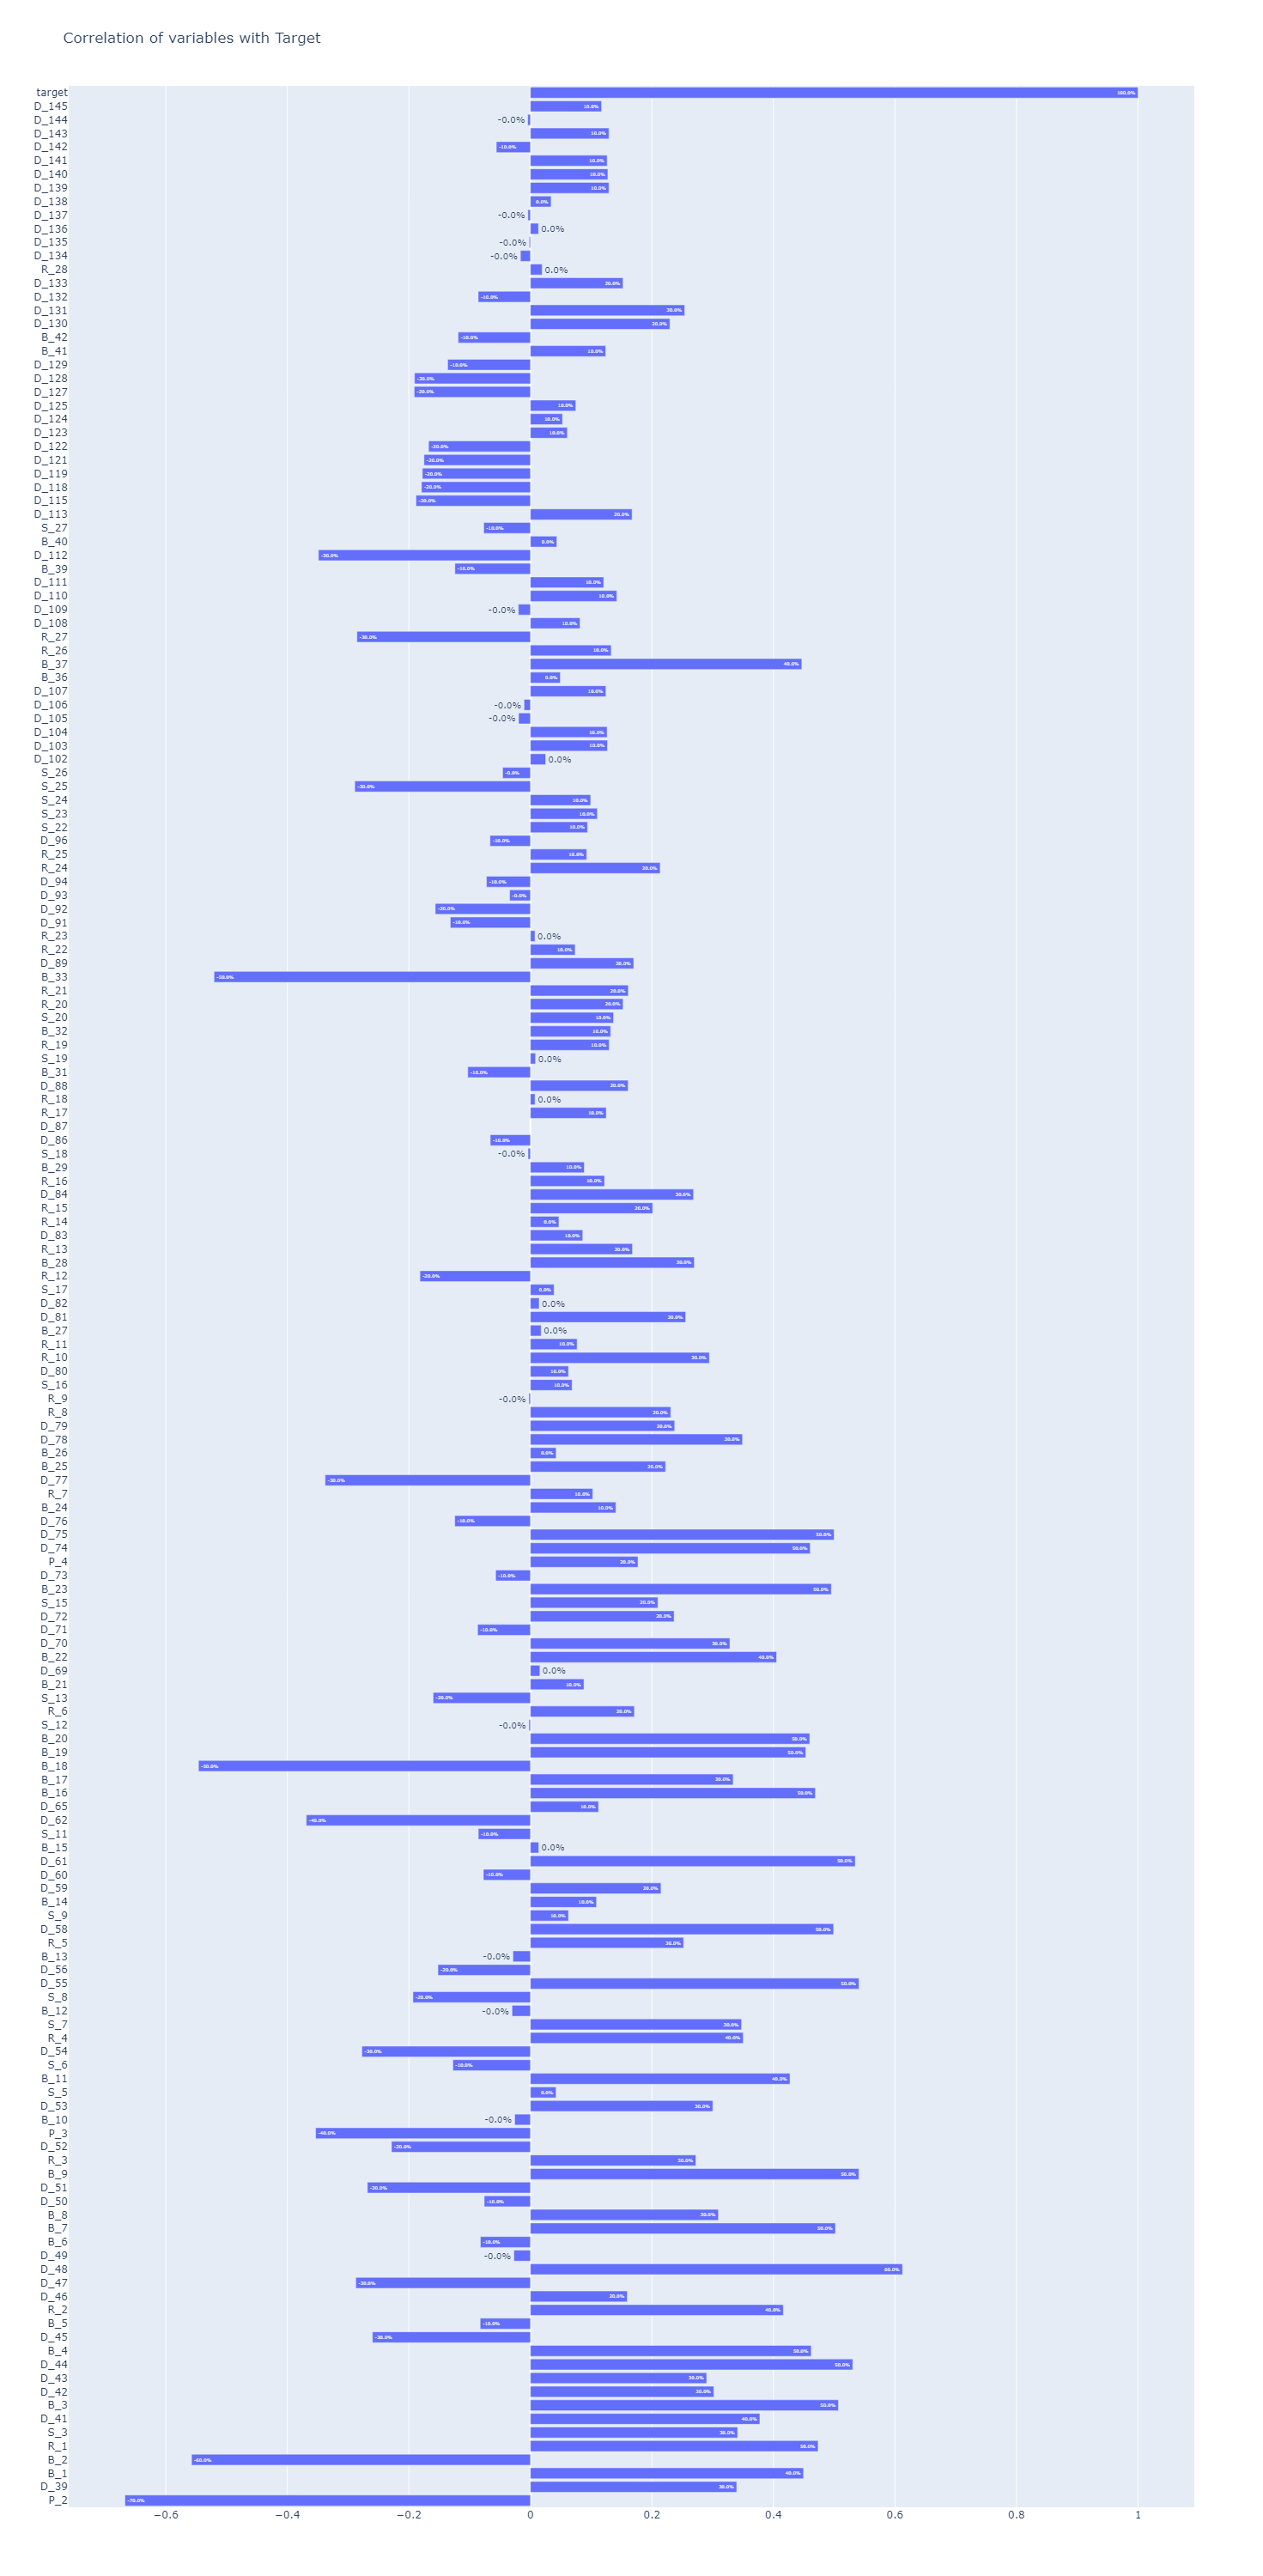

In [28]:
target = train_data1.corrwith(train_data1['target'], axis=0)
val = [str(round(v ,1) *100) + '%' for v in target.values]

fig = go.Figure()
fig.add_trace(go.Bar(y=target.index, x=target.values, orientation='h', text = val))
fig.update_layout(title = "Correlation of variables with Target", width = 700, height = 3000)
fig.show()

del target, val

## Exporting the Datasets to CSV

In [29]:
train_data1.to_csv('data/train_data.csv')
test_data1.to_csv('data/test_data.csv')

## Setting path for the CSV data

In [30]:
train_path = 'data/train_data.csv' # Already with target in it
test_path = 'data/test_data.csv'
sample_path = 'data/sample_submission.csv'

In [31]:
train_data = pd.read_csv(train_path).set_index('customer_ID')
test_data = pd.read_csv(test_path).set_index('customer_ID')
sample_data = pd.read_csv(sample_path)

print(f'Train shape: {train_data.shape}')
print(f'Test shape: {test_data.shape}')

Train shape: (458913, 190)
Test shape: (924621, 189)


# Feature Engineering

## Dealing with missing values and high correlation
Variables >= 80% of missing values will be removed, and the rest will have imputation.

In [32]:
var_null = [c for c in train_data.columns if (train_data[c].isnull().sum()/train_data.shape[0]) >= 0.8]
print(len(var_null))

for v in var_null:
    print(v, end=' ')

23
D_42 D_49 D_66 D_73 D_76 R_9 B_29 D_87 D_88 D_106 R_26 D_108 D_110 D_111 B_39 B_42 D_132 D_134 D_135 D_136 D_137 D_138 D_142 

In [33]:
corr = train_data.corr()
drop_corr = []

for i in range(len(corr.columns) - 1):
   if corr.columns[i] in drop_corr:
      continue

   for j in range(i+1, len(corr.columns)):
      if abs(corr.iloc[i,j]) > 0.9 and corr.columns[j] not in drop_corr:
         drop_corr.append(corr.columns[j])

In [34]:
to_drop = var_null + drop_corr
print(len(to_drop))

39


In [35]:
train_data.drop(to_drop, axis=1, inplace=True)
test_data.drop(to_drop, axis=1, inplace=True)

print(f'Train shape: {train_data.shape}')
print(f'Test shape: {test_data.shape}')

Train shape: (458913, 152)
Test shape: (924621, 151)


In [36]:
del to_drop, var_null, drop_corr

## Undersample data for a balanced dataset

In [37]:
pay = train_data[train_data['target']==0]
default = train_data[train_data['target']==1]

print(f'Payable shape: {pay.shape}, and default shape: {default.shape}')

Payable shape: (340085, 152), and default shape: (118828, 152)


In [38]:
pay = pay.head(len(pay)*3//4)

print(f'Payable shape: {pay.shape}, and default shape: {default.shape}')

Payable shape: (255063, 152), and default shape: (118828, 152)


In [39]:
train_data2 = pd.concat([pay, default]).sort_values(by='S_2')

print(train_data2.shape)
train_data2['target'].value_counts()

del pay, default,

(373891, 152)


## Label encoder for categorical features

In [40]:
from sklearn.preprocessing import LabelEncoder

def remove_or_label(table: pd.DataFrame, method: str) -> pd.DataFrame:
    '''Remove or encode categorical features of a DataFrame.'''
    cat_feat = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

    if method=='label_encoder':
        le = LabelEncoder()
        for feat in cat_feat:
            if feat in table.columns:
                table[feat] = le.fit_transform(table[feat])
    
    elif method=='remove':
        for feat in cat_feat:
            if feat in table.columns:
                table.drop(feat, axis=1, inplace=True)
    
    return table

In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [42]:
X = train_data.drop(['target', 'S_2'], axis=1)
y = train_data['target']

In [43]:
# Identify non-numeric columns
non_numeric_columns = X.select_dtypes(include=['object', 'category']).columns
print("Non-numeric columns:", non_numeric_columns)


Non-numeric columns: Index(['D_63', 'D_64'], dtype='object')


In [44]:
# Convert categorical columns to numeric using LabelEncoder or a similar method
for column in non_numeric_columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column].astype(str))

# Now you can use SimpleImputer on the whole dataset
imp = SimpleImputer(strategy='mean')
X_imputed = imp.fit_transform(X)

In [45]:
#imp = SimpleImputer(strategy='mean')
# scaler = StandardScaler()
# pca = PCA(n_components=108, random_state=42)

In [46]:
X_imputed = imp.fit_transform(X.values)
# X_scaled = scaler.fit_transform(X_imputed)

# pca.fit(X_scaled)

# X_pca = pca.transform(X_scaled)

In [47]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
# plt.xlabel('Number of components')
# plt.ylabel('Explained variance');

In [48]:
# var_ex_ratio = np.cumsum(pca.explained_variance_ratio_*100)

# for ver in range(0, len(var_ex_ratio), 2):
#     print(f'Variance explained by the first {ver} principal components = {round(var_ex_ratio[ver], 2)}%')

## Train Test Split and oversampling dataset

In [49]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

X_ovr, y_ovr = BorderlineSMOTE(random_state=42).fit_resample(X_train, y_train)
print(f'X shape: {X_ovr.shape}')
print(f'y shape: {y_ovr.shape}')
print(y_ovr.value_counts())

X_train = X_train.round(decimals=2)
X_test = X_test.round(decimals=2)

del X, y, X_imputed, # var_ex_ratio, X_pca, X_scaled

X shape: (544136, 150)
y shape: (544136,)
1    272068
0    272068
Name: target, dtype: int64


# Model

In [50]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [51]:
xgb_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'eval_metric': ['auc', 'binary_logloss']
        }



xgb = XGBClassifier(learning_rate=0.02, n_estimators=600,
        objective='binary:logistic', nthread=1)

In [52]:
random_search = RandomizedSearchCV(
    xgb, param_distributions=xgb_params, n_iter=5,
    scoring='roc_auc',
    n_jobs=-2, cv=3,
    verbose=3,
    random_state=42
)

In [53]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=600, n_jobs=None,
                                           nthread=1, num_parallel_tree=None, ...),
                   n_iter=5, n_jobs=-2,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'eval_metric': ['auc',
                                                        'binary_logloss'],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=3)

In [54]:
xgbc = XGBClassifier(n_jobs=-2)
xgbc.fit(
    X_ovr, y_ovr
    )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-2,
              num_parallel_tree=None, random_state=None, ...)

In [55]:
xgbc_pred = xgbc.predict(X_test)

In [56]:
print(classification_report(y_test, xgbc_pred))

              precision    recall  f1-score   support

           0       0.98      0.53      0.69     68017
           1       0.42      0.97      0.58     23766

    accuracy                           0.64     91783
   macro avg       0.70      0.75      0.64     91783
weighted avg       0.84      0.64      0.66     91783



In [57]:
#Reference of these params took from: https://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline
params = {'boosting_type': 'gbdt',
          'n_estimators': 1000,
          'num_leaves': 50,
          'learning_rate': 0.05,
          'colsample_bytree': 0.9,
          'min_child_samples': 2000,
          'max_bins': 500,
          'reg_alpha': 2,
          'objective': 'binary',
          'random_state': 21}

model = LGBMClassifier(**params)

In [58]:
model.fit(
    X_ovr, y_ovr,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    callbacks=[early_stopping(100), log_evaluation(200)],
    eval_metric=['auc, binary_logloss']
)

[LightGBM] [Warning] Unknown parameter: binary_logloss,binary
[LightGBM] [Warning] Unknown parameter: binary_logloss,binary
[LightGBM] [Info] Number of positive: 272068, number of negative: 272068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.282287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74570
[LightGBM] [Info] Number of data points in the train set: 544136, number of used features: 150
[LightGBM] [Warning] Unknown parameter: binary_logloss,binary
[LightGBM] [Warning] Unknown parameter: binary_logloss,binary
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	valid_0's auc: 0.929786	valid_1's auc: 0.930827


LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, max_bins=500,
               min_child_samples=2000, n_estimators=1000, num_leaves=50,
               objective='binary', random_state=21, reg_alpha=2)

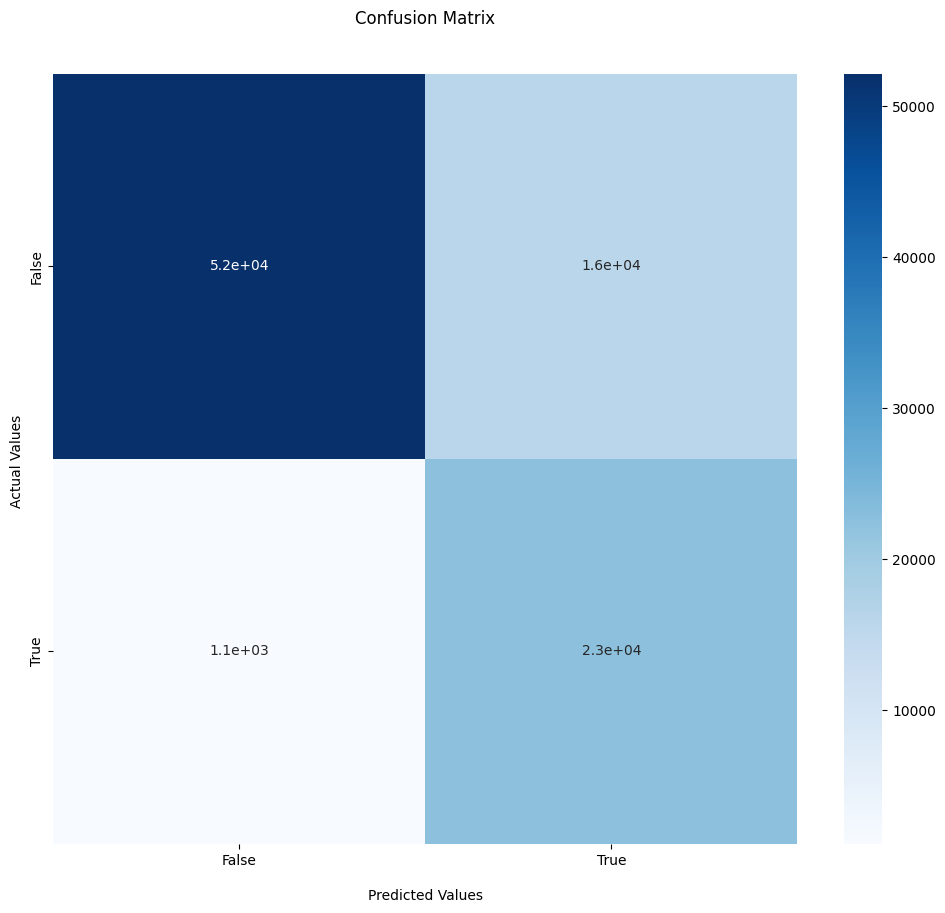

In [59]:
y_pred = model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(12,10))

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86     68017
           1       0.59      0.95      0.73     23766

    accuracy                           0.82     91783
   macro avg       0.78      0.86      0.79     91783
weighted avg       0.88      0.82      0.83     91783



## Export model

In [ ]:
! test -d models || mkdir models

In [62]:
with open('models/model_4.pkl', 'wb') as out:
    pickle.dump(model, out)

## Import model

In [63]:
with open('models/model_4.pkl', 'rb') as entry:
    imp_model = pickle.load(entry)

In [64]:
test_data = remove_or_label(test_data, 'label_encoder')

In [65]:
test_imputed = imp.fit_transform(test_data.drop('S_2', axis=1))

In [66]:
# test_scaled = scaler.fit_transform(test_imputed)
# test_pca = pca.fit_transform(test_scaled)

In [67]:
test_pred = imp_model.predict_proba(test_imputed)

In [68]:
sample_data['prediction'] = test_pred[:, 1]

sample_data.head()

customer_ID  prediction
0  00000469ba478561f23a92a868bd366de6f6527a684c9a...    0.246914
1  00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...    0.107652
2  0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...    0.167124
3  00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...    0.642015
4  00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...    0.768203

In [69]:
sample_data.to_csv('submission.csv',index=False)

[CV 1/3] END colsample_bytree=0.6, eval_metric=auc, gamma=2, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.958 total time= 1.0min
[CV 3/3] END colsample_bytree=0.8, eval_metric=binary_logloss, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=nan total time=   4.1s
[CV 1/3] END colsample_bytree=0.6, eval_metric=auc, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.958 total time=  56.8s
[CV 2/3] END colsample_bytree=0.8, eval_metric=binary_logloss, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=nan total time=   3.9s
[CV 3/3] END colsample_bytree=0.8, eval_metric=auc, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.956 total time=  44.0s
[CV 1/3] END colsample_bytree=0.6, eval_metric=auc, gamma=1.5, max_depth=4, min_child_weight=10, subsample=1.0;, score=0.957 total time=  45.2s
[CV 1/3] END colsample_bytree=0.8, eval_metric=auc, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.956 total 